Na podstawie liczby pierscieni i innych cech ma sklasyfikowac czy slimak jest stary czy mlody

In [4]:
import pandas as pd
df = pd.read_csv("C:\\Users\\rafal\\Downloads\\abalone (1).csv")
display(df.head())

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:

median_rings = df['Rings'].median()
print(f"Mediana liczby pierścieni: {median_rings}")
df['is_old'] = (df['Rings'] > median_rings).astype(int)
# Wyświetlenie pierwszych wierszy z nową kolumną
print("\nDataFrame z nową kolumną 'is_old':")
print(df.head())
# Sprawdzenie, jak rozkładają się klasy
print("\nRozkład klas (0 - młody, 1 - stary):")
print(df['is_old'].value_counts())


Mediana liczby pierścieni: 9.0

DataFrame z nową kolumną 'is_old':
  Type  LongestShell  Diameter  Height  WholeWeight  ShuckedWeight  \
0    M         0.455     0.365   0.095       0.5140         0.2245   
1    M         0.350     0.265   0.090       0.2255         0.0995   
2    F         0.530     0.420   0.135       0.6770         0.2565   
3    M         0.440     0.365   0.125       0.5160         0.2155   
4    I         0.330     0.255   0.080       0.2050         0.0895   

   VisceraWeight  ShellWeight  Rings  is_old  
0         0.1010        0.150     15       1  
1         0.0485        0.070      7       0  
2         0.1415        0.210      9       0  
3         0.1140        0.155     10       1  
4         0.0395        0.055      7       0  

Rozkład klas (0 - młody, 1 - stary):
is_old
0    2096
1    2081
Name: count, dtype: int64


In [6]:
df_processed = pd.get_dummies(df, columns=['Type'], drop_first=False, dtype=int)
df_processed = df_processed.drop('Rings', axis=1)


# KROK 3: Podział na zbiór treningowy i walidacyjny
# (Dokładnie tak, jak w kodzie 'ion')
df_train = df_processed.sample(frac=0.7, random_state=0)
df_valid = df_processed.drop(df_train.index)

# KROK 4: Skalowanie (Min-Max)
# Stosujemy tę samą logikę co w 'ion', ale robimy to poprawniej:
# 1. Wydzielamy X i y
# 2. Obliczamy min/max TYLKO na X_train
# 3. Skalujemy X_train i X_valid (bez ruszania y!)

target_column = 'is_old'  # Nasz cel to teraz 'is_old'

# Wydzielenie X i y dla obu zbiorów
X_train_raw = df_train.drop(target_column, axis=1)
y_train = df_train[target_column]

X_valid_raw = df_valid.drop(target_column, axis=1)
y_valid = df_valid[target_column]

# Obliczenie statystyk (min, max) TYLKO na X_train_raw
max_ = X_train_raw.max(axis=0)
min_ = X_train_raw.min(axis=0)

# Skalowanie (normalizacja) X_train i X_valid
X_train = (X_train_raw - min_) / (max_ - min_)
X_valid = (X_valid_raw - min_) / (max_ - min_)

# KROK 5: Sprawdzenie, czy nie ma kolumn NaN (na wszelki wypadek)
# (Ten krok był w kodzie 'ion', więc go powtarzamy)
X_train.dropna(axis=1, inplace=True)
# Upewniamy się, że zbiór walidacyjny ma te same kolumny
X_valid = X_valid[X_train.columns]


# KROK 6: Wyświetlenie wyników
print("\n--- Gotowe dane do modelu ---")
print(f"Kształt X_train: {X_train.shape}")
print(f"Kształt y_train: {y_train.shape}")
print(f"Kształt X_valid: {X_valid.shape}")
print(f"Kształt y_valid: {y_valid.shape}")

print("\nNagłówek X_train (przeskalowany):")
display(X_train.head())

print("\nNagłówek y_train (cel):")
display(y_train.head())


--- Gotowe dane do modelu ---
Kształt X_train: (2924, 10)
Kształt y_train: (2924,)
Kształt X_valid: (1253, 10)
Kształt y_valid: (1253,)

Nagłówek X_train (przeskalowany):


,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Type_F,Type_I,Type_M
668,0.624113,0.598214,0.300971,0.322804,0.203930,0.319289,0.371365,0.0,0.0,1.0
1580,0.553191,0.553571,0.233010,0.215794,0.191694,0.187623,0.213087,0.0,1.0,0.0
3784,0.723404,0.696429,0.300971,0.442768,0.388951,0.491771,0.351790,0.0,0.0,1.0
463,0.156028,0.133929,0.106796,0.016504,0.014090,0.015142,0.019016,0.0,1.0,0.0
2615,0.758865,0.732143,0.339806,0.533274,0.497590,0.493746,0.418904,0.0,0.0,1.0



Nagłówek y_train (cel):


668     1
1580    0
3784    1
463     0
2615    1
Name: is_old, dtype: int64

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[10]),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),    
    layers.Dense(1, activation='sigmoid'),
])

C:\Users\rafal\PycharmProjects\smart-booking-system\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=300,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.4553
Best Validation Accuracy: 0.7877


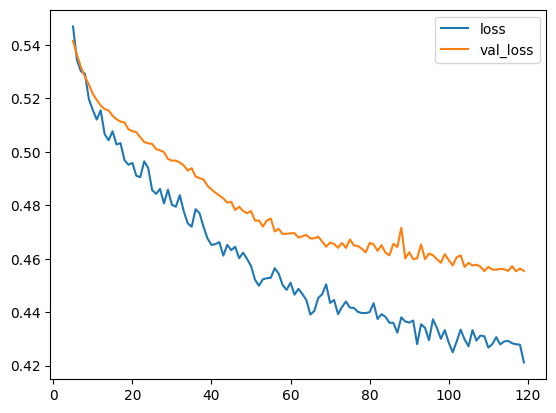

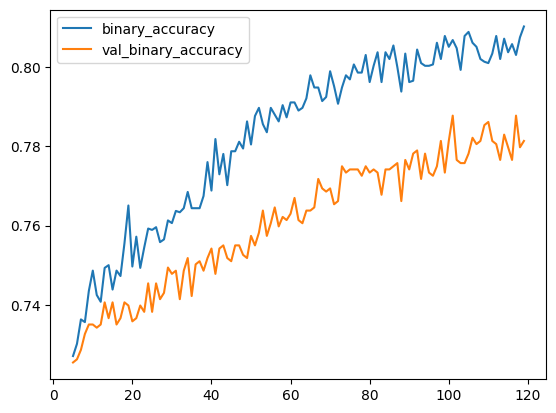

In [10]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))